In [27]:
import os
import requests
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
from bokeh.models import ColumnDataSource, Legend
from bokeh.io import output_notebook, show
from bokeh.palettes import Category10
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource,Legend
from bokeh.io import output_notebook, show
from bokeh.palettes import Category10
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_file
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Marker, AwesomeIcon, FullScreenControl
import requests
import json
import folium
import random
import plotly.graph_objs as go
from plotly.offline import plot, iplot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import mplcursors
import plotly.tools as tls




In [28]:
##
#
# Author: 
# Salim Omar
#
##

# cleaning and preprocessing

csv_path = "../Fire_Incidents.csv"

if not os.path.exists(csv_path):
    # Download CSV from API if it doesn't exist locally
    url = "https://data.sfgov.org/resource/wr8u-xric.json"
    response = requests.get(url)
    df = pd.read_json(response.text)
    df.to_csv(csv_path, index=False)
    print("The data has been readed from ", url)
else:
    # Load CSV from local file
    df = pd.read_csv(csv_path)
    print("The data is found locally")

#df.head()


# cleaning and preprocessing


df['Incident Date'] = pd.to_datetime(df['Incident Date'])
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'])
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'])
df['Close DtTm'] = pd.to_datetime(df['Close DtTm'])

df['Incident Time'] = df['Incident Date'].dt.time
df['Incident month'] = df['Incident Date'].dt.month
df['Incident year'] = df['Incident Date'].dt.year


# Get the data from date 2010-04-01 to 2023-04-01
df = df[(df['Incident year'] >= 2010) &
        (df['Incident year'] <= 2022)]


# print the number of rows
num_rows = df.shape[0]
print("The number of rows is:", num_rows)

# get just the data from Sf city
df = df[(df['City'] == 'SF') | (df['City'] == 'San Francisco')
        | (df['City'] == 'SAN FRANCISCO')]

# Deleting all unnaseccary columns
df.drop(columns=['Exposure Number',
                'Box',
                'Fire Fatalities',
                'Fire Injuries',
                'Civilian Fatalities',
                'Civilian Injuries',
                'Number of Alarms',
                'Mutual Aid',
                'Action Taken Secondary',
                'Action Taken Other',
                'Area of Fire Origin',
                'Ignition Cause',
                'Ignition Factor Primary',
                'Ignition Factor Secondary',
                'Item First Ignited',
                'Human Factors Associated with Ignition',
                'Structure Type',
                'Structure Status',
                'Floor of Fire Origin',
                'Fire Spread',
                'No Flame Spead',
                'Number of floors with minimum damage',
                'Number of floors with significant damage',
                'Number of floors with heavy damage',
                'Number of floors with extreme damage',
                'Detectors Present',
                'Detector Type',
                'Detector Operation',
                'Detector Effectiveness',
                'Detector Failure Reason',
                'Automatic Extinguishing System Present',
                'Automatic Extinguishing Sytem Type',
                'Automatic Extinguishing Sytem Perfomance',
                'Automatic Extinguishing Sytem Failure Reason',
                'Number of Sprinkler Heads Operating'
                ], inplace=True)
# the code for Primary Situation
df['focuse_Situation_by_number'] = df['Primary Situation'].str[:3]

# error rows
df.drop(df[df['ID'] == 140383810 ].index, axis=0, inplace=True)
df.drop(df[df['ID'] == 140660390 ].index, axis=0, inplace=True)
#df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_11672\170815462.py:21: DtypeWarning:

Columns (10,12,13,20,29,38,45,46,55,59) have mixed types. Specify dtype option on import or set low_memory=False.



The data is found locally
The number of rows is: 408448


# Part 1

## 1. Top 10 Primary Situation

In [3]:
##
#
# Author: 
# Salim Omar
#
##

# create a new dataset for top 10 Primary Situation
top10_df = df[['Primary Situation', 'focuse_Situation_by_number','neighborhood_district']].copy()

# replace 2 coulms in 1 
top10_df['Primary Situation'].replace(['745 Alarm system sounded/no fire-accidental',
                                '735 Alarm system sounded due to malfunction'], '745 Alarm system activation', inplace=True)
top10_df = top10_df[top10_df['Primary Situation'] != '554 Assist invalid']

# add Situation_by_code
top10_df['focuse_Situation_by_number'] = top10_df['Primary Situation'].str[:3]
top10_df.head(100)


,Primary Situation,focuse_Situation_by_number,neighborhood_district
205932,745 - Alarm system sounded/no fire-accidental,745,Financial District/South Beach
205933,"711 - Municipal alarm system, Street Box False",711,Lakeshore
205934,353 - Removal of victim(s) from stalled elev.,353,Outer Richmond
205935,"740 - Unintentional alarm, other",740,Financial District/South Beach
205936,"700 - False alarm or false call, other",700,Lakeshore
...,...,...,...
206612,412 - Gas leak (natural gas or LPG),412,Sunset/Parkside
206629,531 - Smoke or odor removal,531,Bayview Hunters Point
206634,442 - Overheated motor,442,South of Market
206635,735 - Alarm system sounded due to malfunction,735,Russian Hill


In [4]:
##
#
# Author: 
# Salim Omar
#
##

# Becouse some of Primary Situation have '-' but it's have the same value and code so I delete 
top10_df['Primary Situation'] = top10_df['Primary Situation'].str.replace('- ', '')
top10_df.dropna(subset=['Primary Situation'], inplace=True)
top10_df['Primary Situation'] = top10_df['Primary Situation'].dropna().apply(
    lambda x: x.split(',')[0])

# print(call_Situation)
call_Situation = top10_df['Primary Situation']
len(call_Situation)
# by using unique() fun we can se the diffrenet type of data

ListOfSituation = call_Situation.unique()
#print(ListOfSituation)

Situation_count = call_Situation.value_counts()

# Get the top 10 most frequent situations
top10 = Situation_count.nlargest(10)
print("The top 1o list\n",top10)



The top 1o list
 Primary Situation
700 False alarm or false call                   40923
711 Municipal alarm system                      36136
745 Alarm system activation                     28400
500 Service Call                                15973
113 Cooking fire                                12227
743 Smoke detector activation                   12174
322 Motor vehicle accident with injuries        11525
151 Outside rubbish                             10503
311 Medical assist                               9521
324 Motor vehicle accident with no injuries.     7791
Name: count, dtype: int64


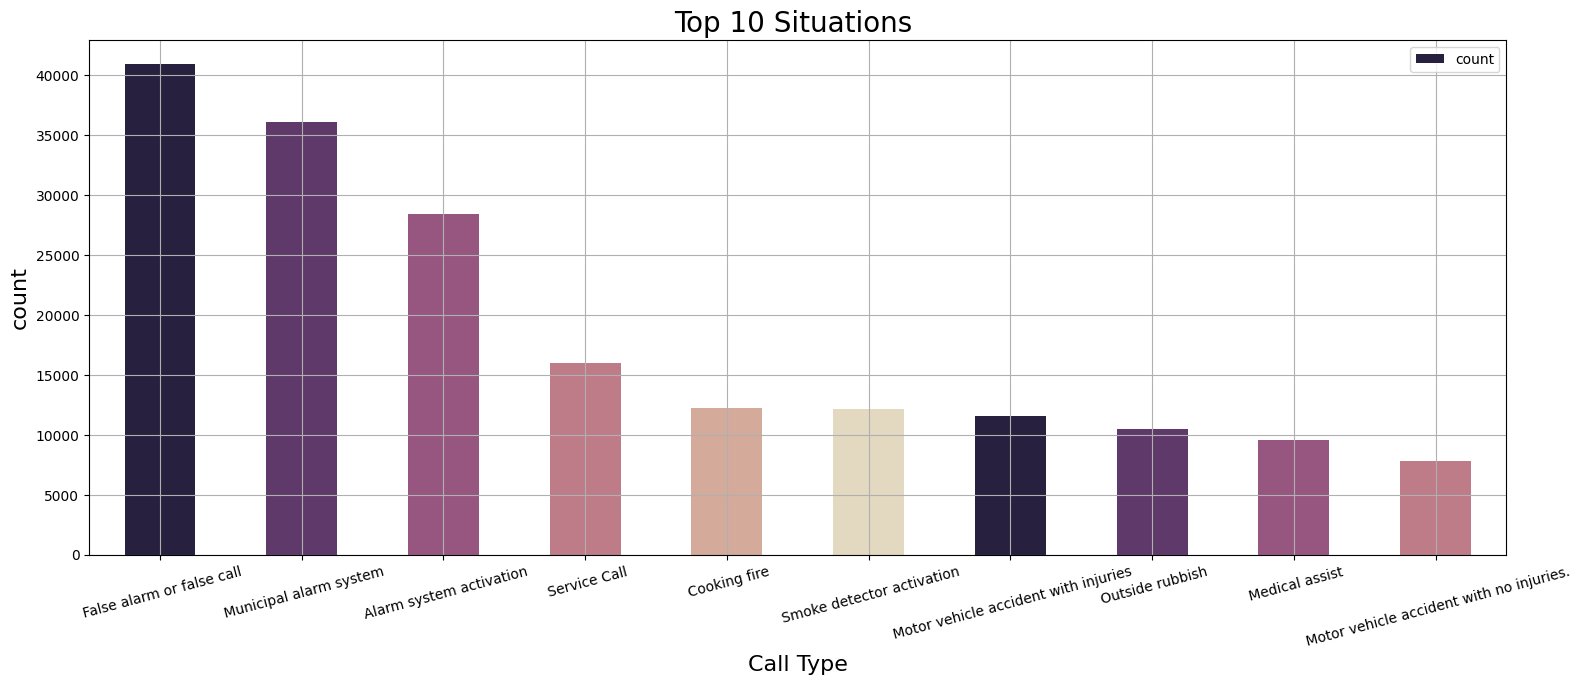

In [5]:
##
#
# Author: 
# Salim Omar
#
##

fig, ax = plt.subplots(figsize=(16, 7))

# define a color map
cmap = sns.color_palette("ch:s=-.2,r=.6")[::-1]

# plot the top 10 situations with the colormap
top10.plot(kind='bar', color=cmap, ax=ax)

# set the chart title and axis labels
plt.title('Top 10 Situations ', fontsize=20)
plt.xlabel('Call Type', fontsize=16)
plt.ylabel('count', fontsize=16)

# add grid lines
ax.grid(True)

# adjust x-tick labels rotation and font size
plt.xticks(rotation=15, fontsize=10)
new_xticklabels = [label.get_text()[3:] for label in ax.get_xticklabels()]
ax.set_xticklabels(new_xticklabels)

# add legend
ax.legend(loc='upper right')


# adjust spacing
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)

# convert to HTML and save
html = mpld3.fig_to_html(fig)
with open('Top_10_plot.html', 'w') as f:
    f.write(html)

# display the chart
plt.show()


## 2. Bokeh plot for top 10 Primary Situation and neighborhood_district

In [6]:
##
#
# Author: 
# Salim Omar
#
##

##
#
#This Bokeh plot shows the count of the top 10 
# Primary Situations in different neighborhood districts.
# The x-axis represents the neighborhood districts,
# and the y-axis represents the count of calls related to each of the top 10 Primary Situations.
# Each bar in the chart represents a specific Primary Situation,
# and the height of the bar represents the count of calls related to that situation in the specific neighborhood district.
# The bars are color-coded based on the Primary Situation they represent, 
# and they can be muted by clicking on the legend on the right-hand side of the chart.
#
##

# get a list of the top 10
top10_situations = top10.index.tolist()
#print(top10_situations)
#print(df['Primary Situation'])

top10_df  = top10_df[top10_df['Primary Situation'].isin(top10_situations)]
print(df['Primary Situation'])
neighborhood_Primary_Situation = top10_df.groupby(['Primary Situation','neighborhood_district']).size().reset_index(name='count')
#print(Battalion_Primary_Situation)

neighborhood_Primary_Situation.to_csv("neighborhood_Primary_Situation.csv")
# calculate the total count for each neighborhood
neighborhood_Primary_counts = top10_df.groupby(['Primary Situation']).size().reset_index(name='total_count')
#print(neighborhood_Primary_counts)

# merge the two dataframes to get the total count for each row
neighborhood_Primary_Situation = pd.merge(neighborhood_Primary_Situation, neighborhood_Primary_counts, on='Primary Situation')
#print(neighborhood_Primary_Situation)


#calculate the count pr ituation pr neighborhood
neighborhood_Primary_Situation['count_pr_Situation_pr_neighborhood'] = neighborhood_Primary_Situation['count'] 


columns = ['Primary Situation', 'neighborhood_district', 'count_pr_Situation_pr_neighborhood']
focusData =  pd.DataFrame(neighborhood_Primary_Situation, columns=columns)
#print(focusData)

# Pivot the dataframe
pivoted_focusData = focusData.pivot_table(index='neighborhood_district', columns='Primary Situation', values='count_pr_Situation_pr_neighborhood')

# Display the pivoted dataframe
#print(pivoted_focusData)


source = ColumnDataSource(data=pivoted_focusData)
## it is a standard way to convert your df to bokeh
output_notebook()


# Define a figure with title and axis labels
p = figure(x_range=source.data['neighborhood_district'], title="counts for call Situation pr neighborhood",x_axis_label='neighborhood',width =1800)
colo = Category10[10]
p.xaxis.major_label_orientation = 1.2
#3. Now we are going to add the bars. In order to do so, we will use vbar (see the guide for help):
bar ={} # to store vbars
items=[]


### here we will do a for loop:
for indx,Situation  in enumerate(pivoted_focusData.columns):
    bar[Situation] =p.vbar(x='neighborhood_district', 
    top=Situation ,
    source=source,
    muted=True, 
    muted_alpha=0.05,
    fill_alpha=1.9,
    color=colo[indx],
    width=0.7)
    items.append((Situation, [bar[Situation]]))

205932        745 - Alarm system sounded/no fire-accidental
205933       711 - Municipal alarm system, Street Box False
205934        353 - Removal of victim(s) from stalled elev.
205935                     740 - Unintentional alarm, other
205936               700 - False alarm or false call, other
                                ...                        
617775          735 Alarm system sounded due to malfunction
617776                 550 Public service assistance, other
617777    745 Alarm system activation, no fire - uninten...
617778                 700 False alarm or false call, other
618180                            531 Smoke or odor removal
Name: Primary Situation, Length: 397746, dtype: object


Loading BokehJS ...

In [7]:
##
#
# Author: 
# Salim Omar
#
##
# The last thing to do is to make legend interactive and display the figure:
legend = Legend(items=items)
p.add_layout(legend, 'left')
p.legend.click_policy = "mute"
output_file('bokeh_Situation_pr_neighborhood.html')
show(p)


## 3. Map to show the distribution for 4 Primary Situations in different Neighborhood

In [8]:
##
#
# Author: 
# Salim Omar
#
##

# dataset for map
df_2022 = df[(df['Incident Date'] >= '2022-12-01') &
            (df['Incident Date'] <= '2022-12-31')]
df_2022.head()
# len(df_2022)
focuse_Situation2 = df_2022['Primary Situation']
ListOfSituation2 = focuse_Situation2.unique()
#print(ListOfSituation2)
len(ListOfSituation2)

focuse_Situation = df_2022['focuse_Situation_by_number']
ListOfSituation = focuse_Situation.unique()
#print(ListOfSituation)
from shapely import wkt
# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('1'), 'focuse_Situation_by_number'] = 'Fire/explosion'
# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('5'), 'focuse_Situation_by_number'] = 'Public service'
# df_2022.loc[df_2022['focuse_Situation_by_number'].str.startswith('7'), 'focuse_Situation_by_number'] = 'Alarm'
# df_2022['focuse_Situation_by_number'].replace(['322','324'], 'Motor vehicle accident', inplace=True)
# df_2022['focuse_Situation_by_number'].replace(['311'], 'Medical assist', inplace=True)
# df_2022['focuse_Situation_by_number'].replace(['700'], 'False alarm/call', inplace=True)
# df_2022['focuse_Situation_by_number'].replace(['322'], 'Motor vehicle accident with injuries', inplace=True)
# df_2022['focuse_Situation_by_number'].replace(['311'], 'Medical assist', inplace=True)
df_2022 = df_2022[df_2022['focuse_Situation_by_number'].isin(['111', '700', '113','150'])]
df_2022['focuse_Situation_by_number'].replace(['150'], 'Outside rubbish fire', inplace=True)
df_2022['focuse_Situation_by_number'].replace(['111'], 'Building fire', inplace=True)
df_2022['focuse_Situation_by_number'].replace(['700'], 'False alarm/call', inplace=True)
df_2022['focuse_Situation_by_number'].replace(['113'], 'Cooking fire', inplace=True)

# keep the important coulmn and drop other 
df_2022 = df_2022.loc[:, ['ID', 'point', 'Incident year', 'focuse_Situation_by_number']]


df_2022['point'] = df_2022['point'].apply(wkt.loads)
df_2022['lon'] = df_2022['point'].apply(lambda p: p.x)
df_2022['lat'] = df_2022['point'].apply(lambda p: p.y)

focuse_Situation = df_2022['focuse_Situation_by_number']
ListOfSituation = focuse_Situation.unique()
print(ListOfSituation)

df_2022.head()
len(df_2022)


['Cooking fire' 'Outside rubbish fire' 'False alarm/call' 'Building fire']


571

In [9]:
##
#
# Author: 
# Salim Omar
#
##

with open('./Planning Neighborhood Groups Map.geojson', 'r') as f:
    data = json.load(f)

data["features"][0]


# Create a dictionary to map focuse_Situation_by_number values to colors
situation_color_dict = {
    # 'Fire/explosion': 'green',
    'Outside rubbish fire': 'orange',
    'False alarm/call': 'purple',
    'Cooking fire': 'blue',
    'Building fire': 'red'
}

color_icon_dict = {
    'red': 'fa-fire',
    # 'green': 'fa-aulance',
    'blue': 'fa-building',
    'orange': 'fa-free-code-camp',
    'purple': 'fa-bell'
}


def random_color(fea):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }


my_map = Map(center=(37.7749, -122.4194), zoom=12,
    layout={'height': '600px', 'width': '100%'})


# Add GeoJSON layer to the map
geojson_layer = GeoJSON(
    data=data,
    style={
        'color': 'gray',
        'weight': 3,
        'fillOpacity': 0.2

    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.4,
    },
    style_callback=random_color,
    name='Neighborhoods',
)


my_map.add_layer(geojson_layer)

# Add markers to the map for each incident in the data
for index, row in df_2022.iterrows():
    location = (row['lat'], row['lon'])
    marker_color = situation_color_dict[row['focuse_Situation_by_number']]
    marker = Marker(location=location, draggable=False,
                    title=row['focuse_Situation_by_number'])
    marker.icon = AwesomeIcon(
        name=color_icon_dict[marker_color], marker_color=marker_color, icon_color='black')
    my_map.add_layer(marker)


my_map.add_control(FullScreenControl())

# Display the map
my_map


Map(center=[37.7749, -122.4194], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [10]:
##
#
# Author: 
# Salim Omar
#
##

import folium
from folium.plugins import Fullscreen

# create a Folium map object from the ipyleaflet map
m = folium.Map(location=my_map.center,
            zoom_start=my_map.zoom, control_scale=True)

color_icon_dict2 = {
    'red': 'fire',
    'blue': 'cloud',
    'orange': 'trash',
    'purple': 'bell'
}

# Add GeoJSON layer to the map
geojson_layer = folium.GeoJson(
    data=data,
    style_function=lambda features: {
        'color': 'gray',
        'weight': 3,
        'fillOpacity': 0.2
    },
    highlight_function=lambda x: {'fillColor': random.choice(
        ['red', 'yellow', 'green', 'orange', 'blue'])},
    name='Neighborhoods',

)
geojson_layer.add_to(m)

# Add markers to the map for each incident in the data
for index, row in df_2022.iterrows():
    location = (row['lat'], row['lon'])
    marker_color = situation_color_dict[row['focuse_Situation_by_number']]
    icon = folium.Icon(icon=color_icon_dict2[marker_color], color=marker_color,icon_color='black')
    marker = folium.Marker(location=location, draggable=False,
                        title=row['focuse_Situation_by_number'], icon=icon)
    marker.add_to(m)

# add Fullscreen control to the map
Fullscreen().add_to(m)

# save the map as an HTML file

m.save('Situation_map.html')
m

## 4. pie chart/donut chart for top 8 heat sources fire-causing

Heat Source
Heat from powered equipment, other                        2734
Heat; direct flame or convection                          1426
Radiated/conducted heat operating equ                     1371
Heat source: other                                        1143
Heat from other open flame or smoking materials, other     855
Hot or smoldering object, other                            800
Cigarette                                                  683
Electrical arcing                                          565
Name: count, dtype: int64


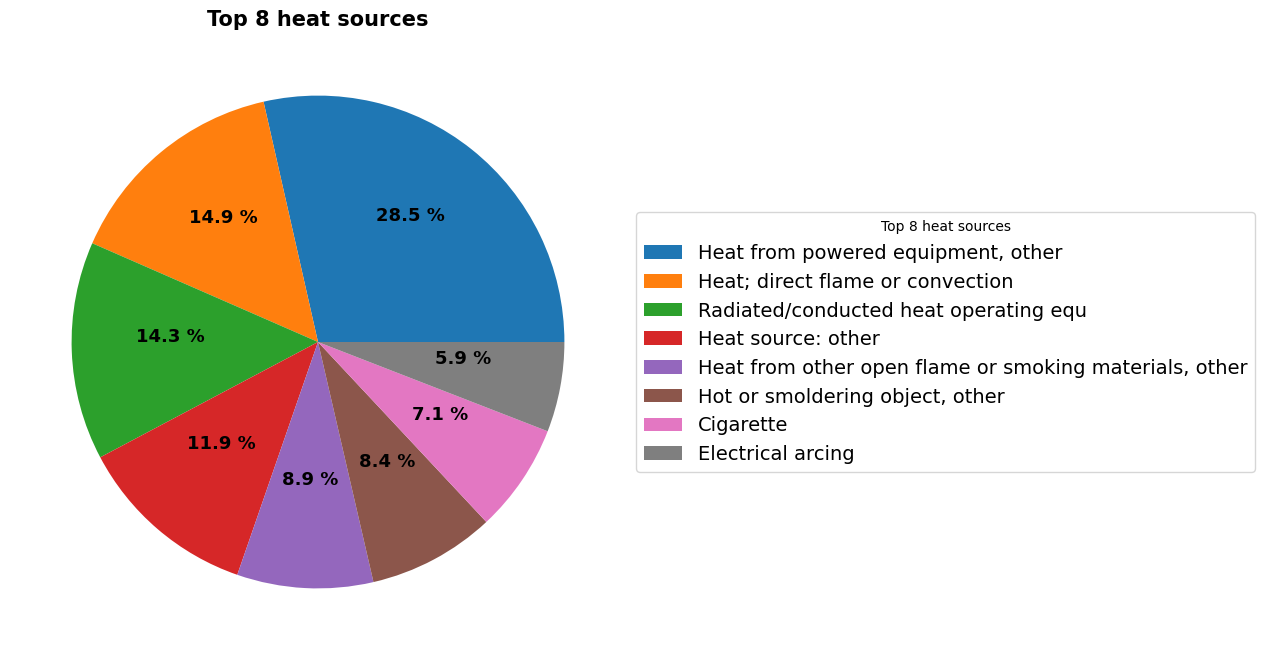

In [11]:
##
#
# Author: 
# Salim Omar
#
##

# Drop rows with missing data and unwanted values
df.dropna(subset=['Heat Source'], inplace=True)
df = df[~df['Heat Source'].isin(['UU Undetermined', 'UU - Undetermined', '-'])]

# Get the top 8 Heat Sources
top_heat_sources1 =df['Heat Source'].str[3:]
top_heat_sources1 = top_heat_sources1.str.replace('- ', '')
top_heat_sources = top_heat_sources1.value_counts().nlargest(8)
print(top_heat_sources)

# Create a figure and axis with equal aspect ratio
fig, ax = plt.subplots(figsize=(10,8), subplot_kw=dict(aspect="equal"))



# Define a function to format the autopct labels with percentage and absolute count
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f} %\n "

# Create the pie chart
wedges, texts, autotexts = ax.pie(top_heat_sources.values, autopct=lambda pct: func(pct, top_heat_sources.values),
                                textprops=dict(color="w"))
# Add legend with the top 8 heat sources and adjust font size
ax.legend(wedges, top_heat_sources.index,
        title="Top 8 heat sources",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        prop={'size': 14}
        )


# Adjust font size and color for the autopct labels
plt.setp(autotexts, size=13, weight="bold", color="black")
# Add title to the plot
ax.set_title("Top 8 heat sources",weight="bold",size=15)

# convert to HTML and save
html = mpld3.fig_to_html(fig)
with open('heat_sources_plot.html', 'w') as f:
    f.write(html)
    

plt.show()

_________________________________________________________________________________________________________________________________

# Part 2

## 1. Bar chart

This code is changing some columns to a alarm date and arrival time format and figuring out the time difference between two of those columns. 

In [29]:

# Author-
# Ali Dadayev 



# This line changes the "Arrival DtTm" column in the DataFrame called "df" into a format that can be understood as a date and time. It does this by using the function called "pd.to_datetime()".
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'])
df['Arrival DtTm'] = df['Arrival DtTm']

# This line converts the "Alarm DtTm" column of the DataFrame df to a datetime format using the pd.to_datetime() function.
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'])

# It calculates the time difference between the "Arrival DtTm" column and the "Alarm DtTm" column and saves it in a new column called "Arrive time_minutes".
df['Arrive time_minutes'] = (df['Arrival DtTm'] - df['Alarm DtTm'])

# df.head()

This code calculates the average (mean) arrival time for a dataset. It uses the mean() method to calculate the average of the "Arrive time_minutes" column of the DataFrame df, which was created in the previous code block by subtracting the "Alarm DtTm" column from the "Arrival DtTm" column.

In [30]:

# Author-
# Ali Dadayev 


# This line calculates the average (mean) value of the "Arrive time_minutes" column of the pandas DataFrame df, and stores the result in the variable average_arrival_time.
average_arrival_time = df['Arrive time_minutes'].mean()

# This line prints out a message to the console that includes the average arrival time.
# print("The average arrival time is:", average_arrival_time)



The code down below calculates the average arrival time of fire department units to emergency incidents, grouped by battalion.

In [31]:

# Author-
# Ali Dadayev 


#This code creates a new column in df called "Arrive time_minutes" that contains the difference between the "Arrival DtTm" and "Alarm DtTm" columns of df.
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)


# Convert to minutes and add a new column

df = df[df['Battalion'] != 'B99']
avg_arrival_time_by_battalion = df.groupby('Battalion')['Arrive time_minutes'].mean().round(2)

#print(avg_arrival_time_by_battalion)


This code generates a bar chart using the Plotly library to visualize the average arrival time of different fire departments or "battalions" to a fire scene.

In [33]:

# Author-
# Ali Dadayev 


# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)
df = df[df['Battalion'] != 'B99']
avg_arrival_time_by_battalion = df.groupby('Battalion')['Arrive time_minutes'].mean().round(2).reset_index()

# Create a bar chart with color gradient
data = [go.Bar(
            x=avg_arrival_time_by_battalion['Battalion'],
            y=avg_arrival_time_by_battalion['Arrive time_minutes'],
            marker=dict(color=avg_arrival_time_by_battalion['Arrive time_minutes'],
                        colorscale='Reds',
                        reversescale=False
                       ),
            text=avg_arrival_time_by_battalion['Arrive time_minutes'],
            textposition='auto'
        )]



# Set layout options
layout = go.Layout(
    title='Average Arrival Time by Battalion',
    xaxis=dict(title='Battalion'),
    yaxis=dict(title='Average Arrival Time (Minutes)'),
    hovermode='closest'
)

# Create the figure and save to an HTML file
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='plot.html')



# Display the plot in the notebook
pyo.iplot(fig)

## 2. Line chart 

This code computes the time it takes for each fire department unit to arrive at the scene of an incident, and creates a new column in the dataset to store these values. It generates a line chart using the Plotly, seaborn and mplcursors libraryies to visualize the the dataset by battalion and year, and calculates the average arrival time for each group and sets some hovering effects on the plot.

In [34]:

# Author-
# Ali Dadayev 


# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)

# Group by battalion and year
df['year'] = df['Incident Date'].dt.year
df_grouped = df.groupby(['Battalion', 'year'])['Arrive time_minutes'].mean().reset_index()

# Create a line plot for each battalion using Plotly
fig = go.Figure()
for battalion in df_grouped['Battalion'].unique():
    data = df_grouped[df_grouped['Battalion'] == battalion]
    fig.add_trace(go.Scatter(x=data['year'], y=data['Arrive time_minutes'], name=battalion, line=dict(width=2)))

# Set layout for the plot
fig.update_layout(
    title="Average Arrival Time by Battalion and Year",
    xaxis_title="Year",
    yaxis_title="Average Arrival Time (Minutes)",
    font=dict(
        family="Arial",
        size=16,
        color="#7f7f7f"
    ),
    legend=dict(
        title="Battalion",
        font=dict(
            family="Arial",
            size=12,
            color="#7f7f7f"
        ),
        yanchor="top",
        y=1,
        xanchor="right",
        x=1
    ),
    plot_bgcolor="#f2f2f2",
    xaxis=dict(
        tickmode='linear',
        tick0=2003,
        dtick=1
    )
)

# Add interactivity to the plot using mplcursors
annotations = [f"{battalion}\nYear: {int(data['year'])}\nAvg. Arrival Time: {data['Arrive time_minutes']:.2f} minutes"
               for battalion, data in df_grouped[['Battalion', 'year', 'Arrive time_minutes']].iterrows()]
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(annotations[sel.target.index]))

# Save the plot to an HTML file and display it in the browser
pyo.plot(fig, filename='battalion_arrival_time.html', auto_open=True)

# Display the plot in the notebook
pyo.iplot(fig)

## 3. Polar bar chart.

This code is creating a polar plot that shows the hourly counts of alarms in the year 2022. 

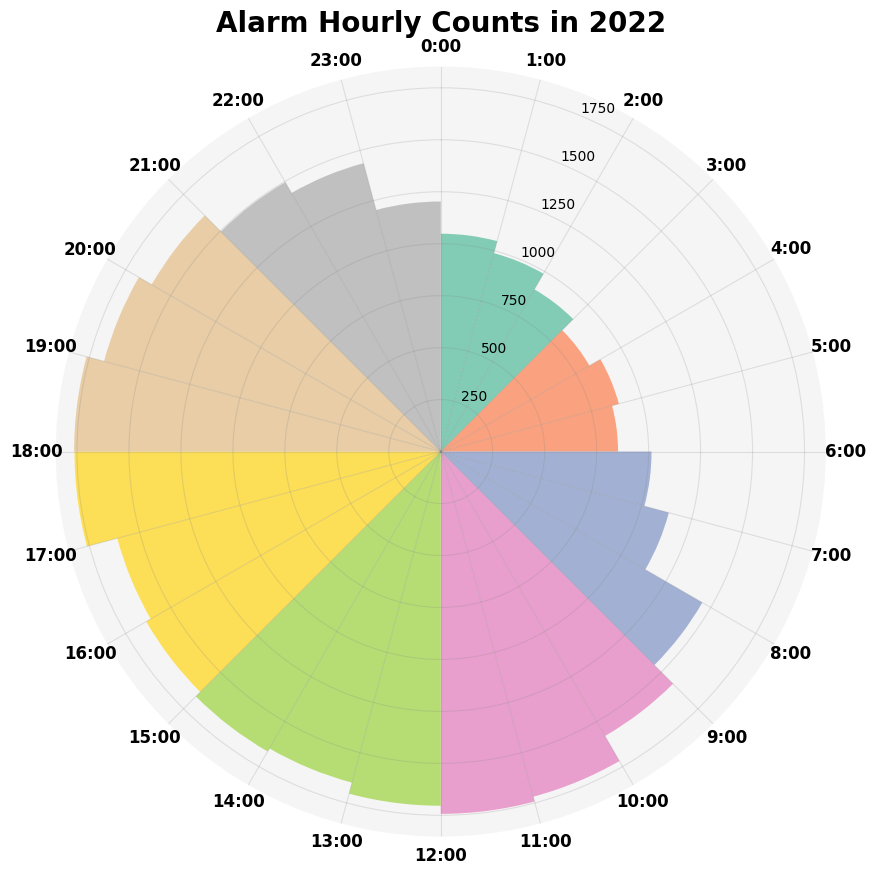

In [35]:

# Author-
# Ali Dadayev 


# Convert the alarm datetime column to datetime
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'])

# Filter for the year 2022
df2 = df[df['Alarm DtTm'].dt.year == 2022]

# Group by hour and count number of alarms
hour_counts = df2.groupby(df2['Alarm DtTm'].dt.hour).size().reset_index(name='counts')

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))

colors = plt.cm.Set2(np.linspace(0, 1, len(hour_counts)))

bars = ax.bar(hour_counts['Alarm DtTm'] * 2 * np.pi / 24, hour_counts['counts'], 
              width=2*np.pi/24, align='edge', color=colors, alpha=0.8)

hours = np.arange(0, 24)
tick_labels = ['{}:00'.format(h) for h in range(24)]
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels(tick_labels, fontsize=12, color='black', fontweight='bold')
ax.set_title('Alarm Hourly Counts in 2022', fontsize=20, pad=25, fontweight='bold')


# Set the starting angle and direction
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Customize the grid and background
ax.grid(color='gray', alpha=0.2)
ax.set_facecolor('whitesmoke')

# Remove unnecessary borders
ax.spines['polar'].set_visible(False)
ax.spines['start'].set_visible(False)
ax.spines['end'].set_visible(False)
ax.spines['inner'].set_visible(False)


plt.show()




_____________________________________

First 
